# Sync soundtrack with video using audio fingerprinting

Audio fingerprinting approach

In [72]:
%matplotlib inline

import re
import sys
from StringIO import StringIO

import numpy as np, scipy, matplotlib, matplotlib.pyplot as plt, IPython.display as ipd
import audfprint.audfprint as audfprint
import librosa, librosa.display

## Perform audio fingerprinting

Using the **audfprint** library https://github.com/dpwe/audfprint

Create the database w/ soundtrack:

In [2]:
db_path = "data/whysoserious.pklz"
s_path = "data/01 Why So Serious?.wav"
v_path = "data/The Dark Knight - Opening Sequence (2008).wav"

cmd = ["_", "new", "--dbase", db_path, s_path]
audfprint.main(cmd)

Fri Feb 16 18:19:22 2018 ingesting #0: data/01 Why So Serious?.wav ...
Added 13324 hashes (24.0 hashes/sec)
Processed 1 files (554.1 s total dur) in 2.6 s sec = 0.005 x RT
Saved fprints for 1 files ( 13324 hashes) to data/whysoserious.pklz (0.00% dropped)


Match it w video track:

In [3]:
cmd = ["_", "match", "--dbase", db_path, v_path, "--find-time-range"]
audfprint.main(cmd)

Fri Feb 16 18:19:37 2018 Reading hash table data/whysoserious.pklz
Read fprints for 1 files ( 13324 hashes) from data/whysoserious.pklz (0.00% dropped)
Fri Feb 16 18:19:47 2018 Analyzed #0 data/The Dark Knight - Opening Sequence (2008).wav of 389.050 s to 15142 hashes
Matched    4.3 s starting at   53.3 s in data/The Dark Knight - Opening Sequence (2008).wav to time   14.5 s in data/01 Why So Serious?.wav with     6 of   548 common hashes at rank  0
Processed 1 files (389.2 s total dur) in 10.2 s sec = 0.026 x RT


Save print output to StringIO instance:

In [4]:
original_stdout = sys.stdout
fprint_result = StringIO()
sys.stdout = fprint_result

Run the match command again:

In [5]:
audfprint.main(cmd)
fprint_result.getvalue()

'Fri Feb 16 18:19:48 2018 Reading hash table data/whysoserious.pklz\nRead fprints for 1 files ( 13324 hashes) from data/whysoserious.pklz (0.00% dropped)\nFri Feb 16 18:19:57 2018 Analyzed #0 data/The Dark Knight - Opening Sequence (2008).wav of 389.050 s to 15142 hashes\nMatched    4.3 s starting at   53.3 s in data/The Dark Knight - Opening Sequence (2008).wav to time   14.5 s in data/01 Why So Serious?.wav with     6 of   548 common hashes at rank  0\nProcessed 1 files (389.2 s total dur) in 9.8 s sec = 0.025 x RT\n'

Let's set the stdout back and format `fprint_result`:

In [6]:
sys.stdout = original_stdout
fprint_result = fprint_result.getvalue()

And then parse the result for the info we want:

In [68]:
# re.search(r"Matched.*Processed", fprint_result).group()
fprint_data_str = re.search("Matched.*", fprint_result).group()
# fprint_data_list = re.findall("\d+[\.]*\d+", fprint_data_str)

fprint_length = float(re.search("(?<=Matched)\s+\d+[\.]*\d+", fprint_data_str).group().strip())
fprint_vt = float(re.search("(?<=starting at)\s+\d+[\.]*\d+", fprint_data_str).group().strip())
fprint_st = float(re.search("(?<=to time)\s+\d+[\.]*\d+", fprint_data_str).group().strip())
fprint_common_hashes = float(re.search("(?<=with)\s+\d+\s+(?=of)", fprint_data_str).group().strip())
fprint_total_hashes = float(re.search("\d+\s+(?=common hashes)", fprint_data_str).group().strip())
fprint_rank = float(re.search("(?<=at rank)\s+\d+", fprint_data_str).group().strip())

(fprint_length, fprint_vt, fprint_st, fprint_common_hashes, fprint_total_hashes, fprint_rank)

(4.3, 53.3, 14.5, 6.0, 548.0, 0.0)

## Load audio files

In [64]:
s, sr = librosa.load(s_path)
v,_ = librosa.load(v_path)

Encapsulating some of the alignment code from the previous DTW-approach notebook:

In [75]:
def align_tracks(audio_tup, time_tup, sr):
    s, v = audio_tup
    st, vt = time_tup
    st_vt_diff = abs(st - vt)
    print("st_vt_diff={}".format(st_vt_diff))
    
    # Pad at beginning (to align)
    offset_samps = librosa.time_to_samples(st_vt_diff, sr=sr)
    s_aligned, v_aligned = s, v

    if st < vt:
        s_aligned = np.concatenate((np.zeros(offset_samps), s), axis=0)
    else:
        v_aligned = np.concatenate((np.zeros(offset_samps), v), axis=0)

    # Pad at end (to normalize duration) 
    sv_length_diff = abs(len(s_aligned) - len(v_aligned))
    if len(s_aligned) < len(v_aligned):
        s_aligned = np.concatenate((s_aligned, np.zeros(sv_length_diff)), axis=0)
    elif len(v_aligned) < len(s_aligned):
        v_aligned = np.concatenate((v_aligned, np.zeros(sv_length_diff)), axis=0)
        
    print("New length: {}".format(len(s_aligned)))
    
    return (s_aligned, v_aligned)

In [76]:
sa, va = align_tracks((s, v), (fprint_st, fprint_vt), sr)

st_vt_diff=38.8
New length: 13073651


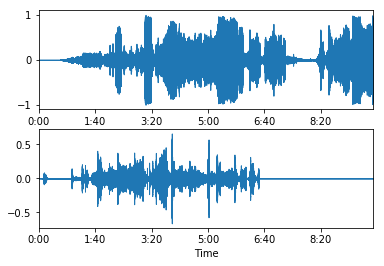

In [73]:
plt.subplot(2, 1, 1)
librosa.display.waveplot(sa, sr=sr)
plt.subplot(2, 1, 2)
librosa.display.waveplot(va, sr=sr)

In [77]:
ipd.Audio((sa + va)[:sr * 120], rate=sr)